In [1]:
%load_ext autoreload
%autoreload 2

# Precision-Recall joint uncertainty

MMU provides two methods for modelling the joint uncertainty on precision and recall.

## Multinomial approach

The Multinomial approach computes the profile log-likelihoods scores for a grid around the precision and recall. The bounds of the grid are determined by ``n_sigmas`` times the standard deviation of the marginals. The scores are chi2 distributed with 2 degrees of freedom.

The Multinomial approach is usually robust for relatively low statistics tests.
Additionally it is valid for the extreme values of precision and recall, which the Bivariate-Normal approach is not. However, the Multinomial approach does not allow the statistical uncertainty of the train set to be incorporated which the Bivariate-Normal does.


## Bivariate-Normal approach

The statistical/sampling uncertainty over the Precision and Recall are modelled
as a Bivariate-Normal over the linearly propagated errors of the confusion
matrix. For a threshold/confusion matrix a covariance matrix is computed which is used to determine the elliptical uncertainty.
The curve uncertainty computes chi2 scores in a similar manner to Multinomial approach.

Note that the Bivariate-Normal (Elliptical) approach is only valid for medium to high statistic datasets. A warning is raised when the Normal approximation to the Binomial may not be valid. Additionally, the estimation is not valid for the extremes of precision/recall. However, the train set uncertainty can be added to the test uncertainty.

## Threshold vs curve uncertainty

Both methods can be applied for a specific threshold or over the precision recall curve. The curve uncertainty represents a conservative view on the uncertainty.
The precision-recall grid is divided into, by default, 1000 bins per axis.
For each bin in the two dimensional grid we retain the minimum score, highest probability, over the thresholds. This means that for any threshold, the curve's CI will never be smaller than the CI of the corresponding threshold.
Hence, the curve uncertainty can slightly over-cover the true confidence interval.
To help with this the curve methods provide functionality to overlay threshold uncertainty(ies) on the curve. 





In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [4]:
import mmu
from mmu.viz.utils import _set_plot_style

In [5]:
%matplotlib inline
_ = _set_plot_style()

### Generate data

Here we use scikit's make_classifaction to generate a toy data set that we fit with Logistic regression.
We use 500 points for the train set and 500 for the test set.

In [6]:
# generate seeds to be used by sklearn
# do not use this in real scenarios,
# it's a convenience only used in the tutorial notebooks
seeds = mmu.commons.utils.SeedGenerator(234)

# generate 2 class dataset
X, y = make_classification(
    n_samples=1000, n_classes=2, random_state=seeds()
)

# split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=seeds()
)
# fit a model
model = LogisticRegression(solver='lbfgs')
model.fit(X_train, y_train)

# predict probabilities, for the positive outcome only
y_score = model.predict_proba(X_test)[:, 1]


## Multinomial uncertainty

### Threshold uncertainty

If you have selected an classification/discrimination threshold you may want to evaluate the test-set sampling uncertainty of this classifier. MMU provides a simple way to achieve this.

`mmu.PrecisionRecallUncertainty` also available under the alias `PRU` is an estimator for the joint precision-recall uncertainty at a specific threshold

We instantiate the class by calling the `from_scores` method, this follows the sklearn API for e.g. ConfusionMatrixDisplay



In [7]:
pr_err = mmu.ROCU.from_scores(y_test, y_score, threshold=0.5) #, n_threads=1)

Alternatively we could have instantiated the uncertainty estimator with:

**Predictions**
```python
y_pred = model.predict(X_test)
PRMU.from_predictions(y_test, y_pred)
```

**Confusion matrix**
```python
PRMU.from_confusion_matrix(conf_mat)
```

**Trained classifier**
```python
PRMU.from_classifier(model, X_test, y_test)
```
Note that the last option requires the classifier to have the methods `predict_proba`

### Attributes

A number of attributes are set during instantiation, most importantly:
* **conf_mat** : np.ndarray[int64]
    * the confusion_matrix with layout
| | |
|---------------|----------------|
| True Negative | False Positive |
| False Negative | True Positive |
    
* **precision** : float
    * the Positive Predictive Value aka positive precision
* **recall** : float
    * True Positive Rate aka Sensitivity aka positive recall
* **chi2_scores** : np.ndarray[float64]
    * the profile log-likelihoods scores with are distributed accoring to a
    chi2 distribution with 2DF

The attributes that are Numpy arrays can be retrieved as a DataFrame using the 
`get_<attribute_name>` methods.

In [8]:
pr_err.get_conf_mat()

estimated         
                   negative positive
observed negative       201       55
         positive        41      203

### Plotting

The `PrecisionRecallUncertainty` class provides a plot method which will plot the precision and recall given the threshold and a settable confidence interval.

By default three confidence intervals are plotted, respectively 1, 2, and 3 standard deviations. Which are approximate the 68%, 95% and 99% CIs.

Alternative, we can specify the alpha's of the confidence interval(s)

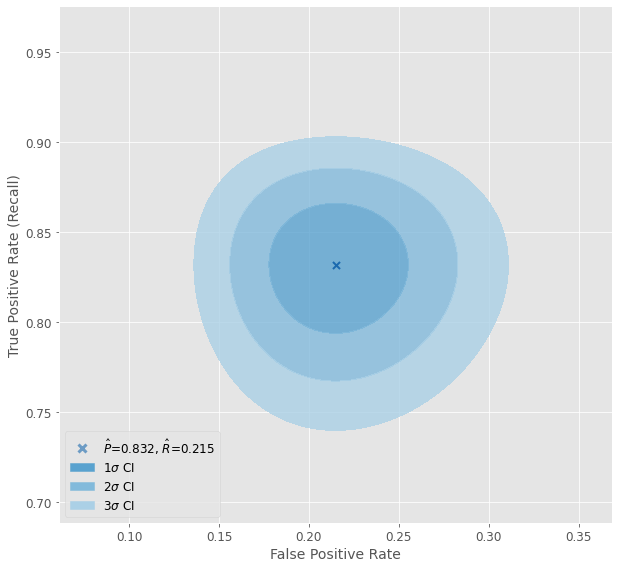

In [12]:
ax = pr_err.plot()

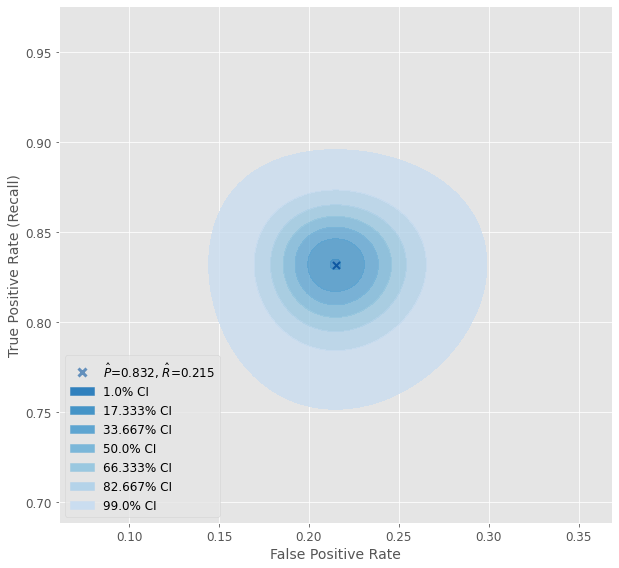

In [13]:
# we can set any arbitraty number of levels
ax = pr_err.plot(levels=np.linspace(0.01, 0.99, 7), equal_aspect=True)

The specifc discrimination threshold can easily be added to a precision recall plot

Here we use `mmu.auto_thresholds`, a utility function that computes all the thresholds that result in a different confusion matrix, much like sklearn's `precision_recall_curve` does. 

Although optimial, for large test sets it can become inconvenient to have so many thresholds. `mmu.auto_thresholds` takes the optional `max_steps` parameter which limits the number points in the thresholds. It does so by performing weighted sampling where points close to each other increase the probability of being selected.

In [14]:
thresholds = mmu.auto_thresholds(y_score)
prec, rec = mmu.ROC_curve(y_test, y_score, thresholds)

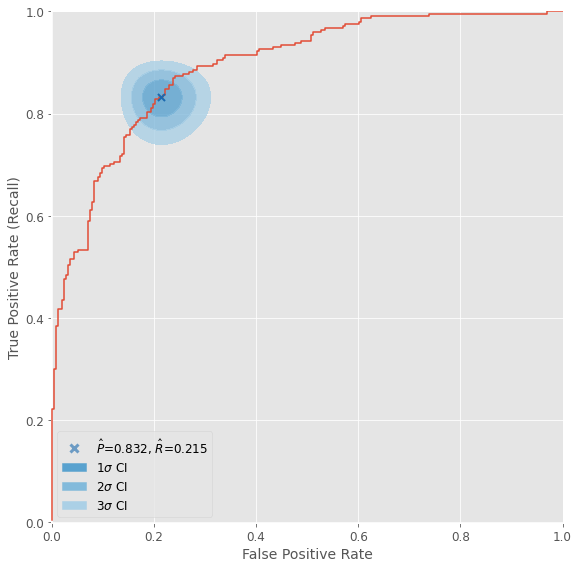

In [15]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(rec, prec, zorder=4)
ax = pr_err.plot(ax=ax)

**Combining threshold plots**

To compare two thresholds or compare the uncertainties of two model you can plot them together quite easily.

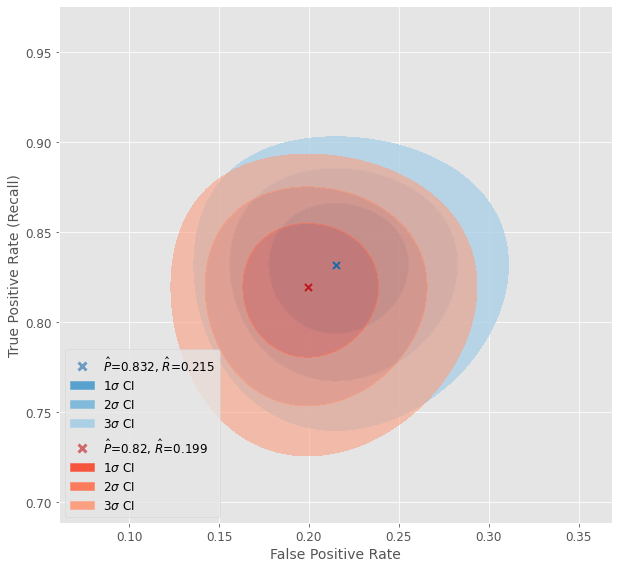

In [16]:
pr_err_alt = mmu.ROCU.from_scores(y_test, y_score, threshold=0.53)

fig, ax = plt.subplots(figsize=(12, 8))
ax = pr_err.plot(ax=ax, other=pr_err_alt, other_kwargs={'alpha': 0.6})

Configuration

The most import setting when it comes to the computation of the uncertainty is the number standard deviations (`n_sigmas`) from the precision, recall that determine the boundaries of the grid. By default `n_sigmas` is 7, this can often be made smaller.

A too small value for `n_sigmas` can be recognised by straight cuts in the uncertainty contour. Here we artificially set the `n_sigmas` too low to demonstrate.

(0.74, 0.92)

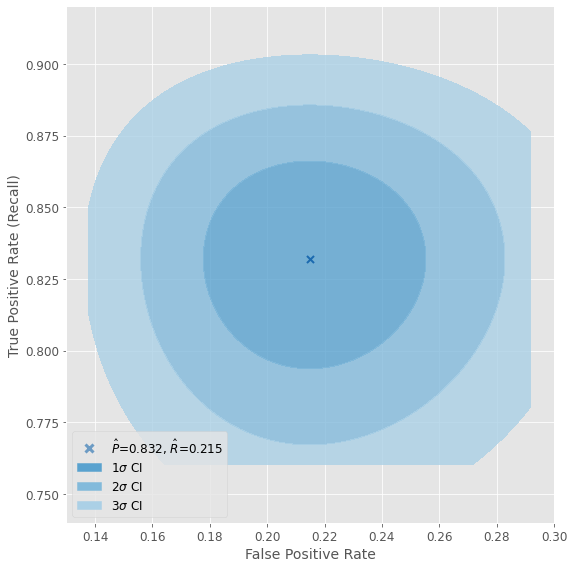

In [17]:
fig, ax = plt.subplots(figsize=(12, 8))
mmu.ROCU.from_scores(y_test, y_score, n_sigmas=3.).plot(ax=ax)
ax.set_xlim((0.13, 0.30))
ax.set_ylim((0.74, 0.92))

## Precision-Recall curve uncertainty

If you want to plot the uncertainty for the entire PR curve the most correct thing would be to plot the contour for each classification threshold. Unfortunately this becomes fairly slow and hard to read.

Hence we provide a conservative alternative.

`PrecisionRecallCurveUncertainty (PRCU)` models the uncertainty in the same way as the method for a single classification threshold. However, rather than drawing multiple countours we draw a countour(s) over the precision-recall grid.
For each bin in the grid we compute the profile log-likelihood (PLL) and store the minimum PLL over the thresholds. In other words, we show the region that contains the highest p-values for any threshold.

This by nature is a conservative approach that should not be used for inference.
It does allow us to visualise the uncertainty over the entire curve in a reasonable time.

In [18]:
pr_curve_err = mmu.ROCCU.from_scores(y_test, y_score)

Note that we don't specify the thresholds, when thresholds is None we use ``mmu.auto_thresholds`` which determines all the threhsolds that result in a different confusion matrix.

### Attributes

A number of attributes are set during instantiation, most importantly:
* **conf_mat** : np.ndarray[int64]
    * the confusion_matrix with layout (N, 4)
| | | | |
|---------------|----------------|---------------|----------------|
| True Negative | False Positive | False Negative | True Positive |
    
* **precision** : np.ndarray[float64]
    * the Positive Predictive Value aka positive precision
* **recall** : np.ndarray[float64]
    * True Positive Rate aka Sensitivity aka positive recall
* **chi2_scores** : np.ndarray[float64]
    * the profile log-likelihoods scores with are distributed accoring to a
    chi2 distribution with 2DF

The attributes that are Numpy arrays can be retrieved as a DataFrame using the 
`get_<attribute_name>` methods.

<AxesSubplot:xlabel='False Positive Rate', ylabel='True Positive Rate (Recall)'>

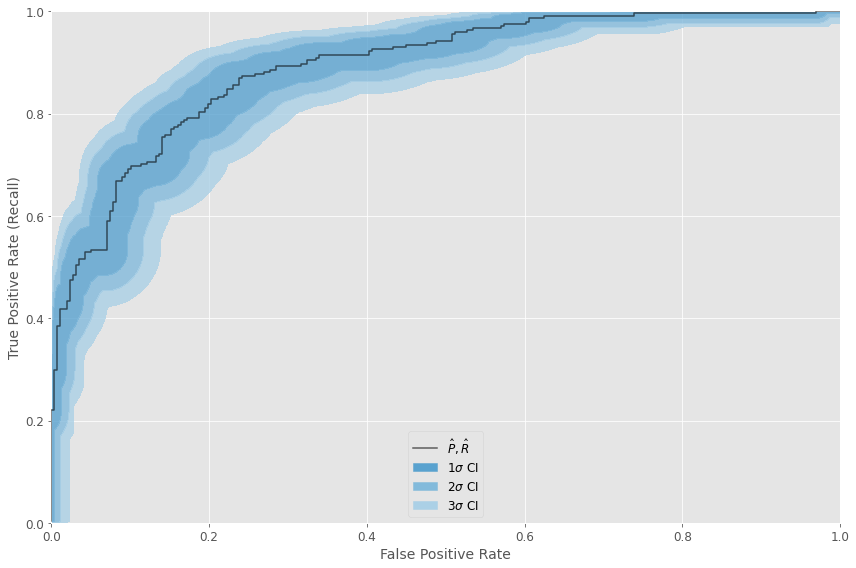

In [19]:
pr_curve_err.plot()

As before we can easily add point uncertainties to the curve plot

In [20]:
pr_err_95 = mmu.ROCU.from_scores(y_test, y_score, threshold=0.95, n_sigmas=8)

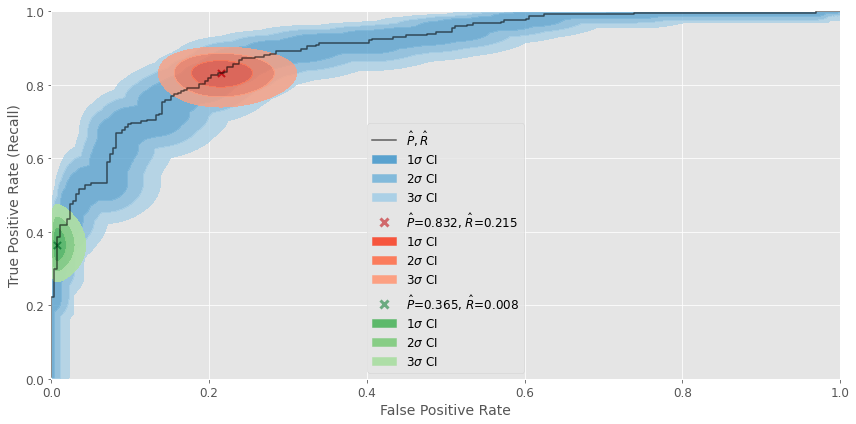

In [21]:
fig, ax = plt.subplots(figsize=(12, 6))
ax = pr_curve_err.plot(
    ax=ax,
    cmap='Blues',
    point_uncertainty=[pr_err, pr_err_95],
    point_kwargs=[{'cmap': 'Reds'}, {'cmap': 'Greens', 'alpha':0.95}]
)


## Elliptical uncertainty

The bivariate-normal (elliptical) approach has can be selected by setting ``method`` to one of ``bivariate``, ``bvn`` or ``eliptical``

### Attributes

A number of attributes are set during instantiation, most importantly:
* **conf_mat** : np.ndarray[int64]
    * the confusion_matrix with layout
| | |
|---------------|----------------|
| True Negative | False Positive |
| False Negative | True Positive |
    
* **precision** : float
    * the Positive Predictive Value aka positive precision
* **recall** : float
    * True Positive Rate aka Sensitivity aka positive recall
* **cov_mat** : np.ndarray[float64]
    * the covariance matrix of precision and recall with layout
| | |
| --------------- | --------------- |
| $\sigma_{P}^{2}$ | $\sigma_{P, R}$ |
| $\sigma_{P, R}$ | $\sigma_{R}^{2}$ |

The attributes that are Numpy arrays can be retrieved as a DataFrame using the 
`get_<attribute_name>` methods.

To reiterate, the elliptical approach is not valid for edge cases as can be seen in the plot below

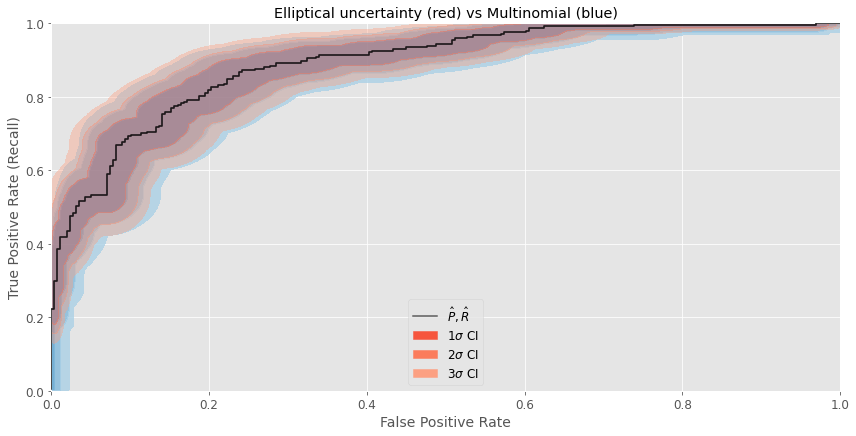

In [22]:
pr_curve_err_alt = mmu.ROCCU.from_scores(y_test, y_score, method='bvn')
fig, ax = plt.subplots(figsize=(12, 6))
ax = pr_curve_err.plot(ax=ax)
ax = pr_curve_err_alt.plot(ax=ax, alpha=0.4, cmap='Reds')
ax.set_title('Elliptical uncertainty (red) vs Multinomial (blue)');